In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)

### 1. Observational data generation

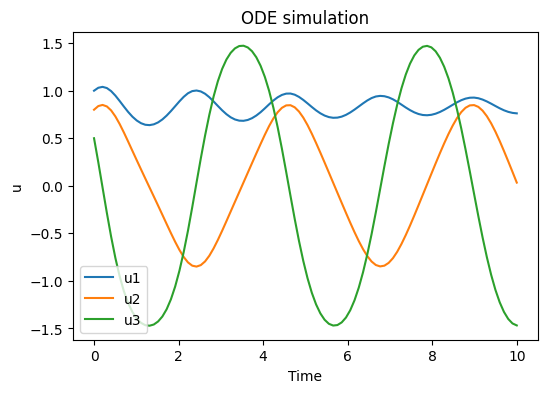

In [51]:
def simulate_ODEs(u_init, t_span, obs_num):
    """Simulate the ODE system and obtain observational data. 
    
    Args:
    ----
    u_init: list of initial condition for u1, u2, and u3
    t_span: lower and upper time limit for simulation
    obs_num: number of observational data points
    
    Outputs:
    --------
    u_obs: observed data for u's
    """
    
    # Target ODEs
    def odes(t, u):
        du1dt = np.exp(-t/10) * u[1] * u[2]
        du2dt = u[0] * u[2]
        du3dt = -3 * u[0] * u[1]
        return [du1dt, du2dt, du3dt]
    
    # Solve ODEs
    t_eval = np.linspace(t_span[0], t_span[1], obs_num)
    sol = solve_ivp(odes, t_span, u_init, method='RK45', t_eval=t_eval)
    
    # Restrcture solution
    u_obs = np.column_stack((sol.t, sol.y[0], sol.y[1], sol.y[2]))
    
    return u_obs

# Set up simulation
u_init = [1, 0.8, 0.5]
t_span = [0, 10]
obs_num = 100

# Solve ODEs
u_obs = simulate_ODEs(u_init, t_span, obs_num)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(u_obs[:, 0], u_obs[:, 1], label='u1')
plt.plot(u_obs[:, 0], u_obs[:, 2], label='u2')
plt.plot(u_obs[:, 0], u_obs[:, 3], label='u3')
plt.legend()
plt.xlabel('Time')
plt.ylabel('u')
plt.title('ODE simulation')
plt.show()

In [52]:
# u_net
class u_net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(u_net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, output_dim)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
        
        
# f_net
class f_net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(f_net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, output_dim)
        
        self.a = nn.Parameter(torch.tensor([-1.0]))
        self.b = nn.Parameter(torch.tensor([1.0]))
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [53]:
# Train data to tensor
ts_train = torch.tensor(u_obs[:, 0], requires_grad=True, dtype=torch.float32).view(-1,1).to(device)
us_train = torch.tensor(u_obs[:, 1:], requires_grad=True, dtype=torch.float32).to(device)

In [54]:
# # Create batch data
# batch_size = 32
# train_data = torch.utils.data.TensorDataset(ts_train, us_train)
# train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [55]:
def residuals(u_net: nn.Module, f_net: nn.Module):
    t = np.linspace(t_span[0], t_span[1], 1000)
    t = torch.tensor(t, requires_grad=True, dtype=torch.float32).view(-1,1).to(device)
    
    u = u_net(t).to(device)
    f = f_net(torch.cat((t, u), 1)).to(device)
    
    u_t_1 = torch.autograd.grad(u[:,0], t, grad_outputs=torch.ones_like(u[:,0]), create_graph=True)[0]
    u_t_2 = torch.autograd.grad(u[:,1], t, grad_outputs=torch.ones_like(u[:,1]), create_graph=True)[0]
    u_t_3 = torch.autograd.grad(u[:,2], t, grad_outputs=torch.ones_like(u[:,2]), create_graph=True)[0]
    
    error_1 = u_t_1 - f[:,0]
    error_2 = u_t_2 - f[:,1]
    error_3 = u_t_3 - (f_net.a * u[:,0] * u[:,1] + f_net.b)
    
    e_1 = torch.mean(error_1)
    e_2 = torch.mean(error_2)
    e_3 = torch.mean(error_3)

    return (e_1**2 + e_2**2 + e_3**2)

In [56]:
unet = u_net(1, 3).to(device)
fnet = f_net(4, 2).to(device)
optimizer = torch.optim.Adam(list(unet.parameters()) + list(fnet.parameters()), lr=0.001)
criterion = nn.MSELoss()

EPOCHS = 5000
LOSS = []
for epoch in range(EPOCHS):
# for ts_train, us_train in train_loader:
    u = unet.forward(ts_train)
    f = fnet.forward(torch.cat((ts_train, u), 1))
    
    loss_ic = (torch.mean(u[0] - torch.tensor([1.0, 0.8, 0.5]).to(device)))**2

    loss_ode = residuals(unet, fnet) 
    loss_data = criterion(u, us_train)        
    loss = loss_data +  loss_ode + loss_ic
    
    LOSS.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}')
        print(f'    ODE Loss: {loss_ode} IC loss: {loss_ic}')
        print(f'    Parameter a: {fnet.a.item()}')
        print(f'    Parameter b: {fnet.b.item()}')

Epoch 1/5000, Loss: 2.8723959922790527
    ODE Loss: 0.8645650148391724 IC loss: 0.9611629247665405
    Parameter a: -1.0010000467300415
    Parameter b: 0.9990000128746033
Epoch 101/5000, Loss: 1.5798850059509277
    ODE Loss: 0.24145787954330444 IC loss: 0.037798669189214706
    Parameter a: -1.1158344745635986
    Parameter b: 0.9050629734992981
Epoch 201/5000, Loss: 0.6702954769134521
    ODE Loss: 0.0033451823983341455 IC loss: 0.005073437001556158
    Parameter a: -1.2237370014190674
    Parameter b: 0.8358616828918457
Epoch 301/5000, Loss: 0.564727246761322
    ODE Loss: 0.008503888733685017 IC loss: 0.0023686522617936134
    Parameter a: -1.2621054649353027
    Parameter b: 0.8182131052017212
Epoch 401/5000, Loss: 0.5410283803939819
    ODE Loss: 0.007569416891783476 IC loss: 0.0016536558978259563
    Parameter a: -1.3043441772460938
    Parameter b: 0.7986931800842285
Epoch 501/5000, Loss: 0.5224551558494568
    ODE Loss: 0.006288402248173952 IC loss: 0.0012836934765800834
   

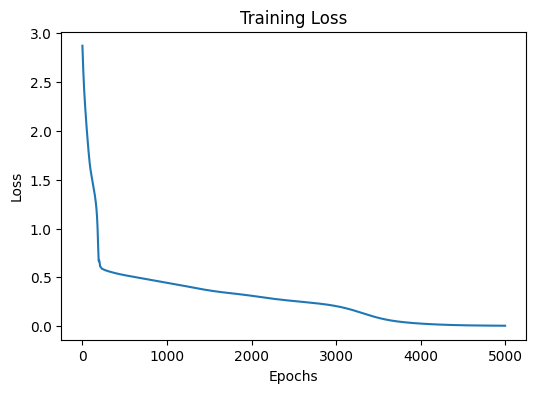

In [57]:
# Plot LOSS
plt.figure(figsize=(6, 4))
plt.plot(LOSS)
# plt.ylim([0, 0.1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


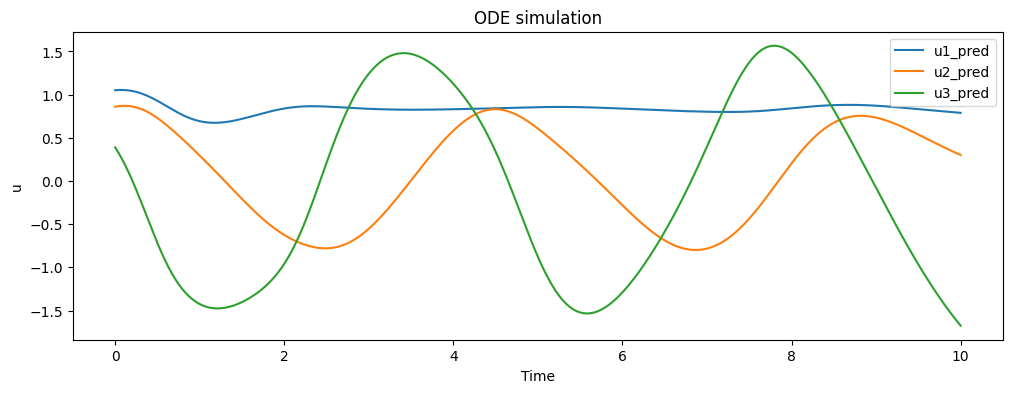

In [59]:
t_test = torch.tensor(np.linspace(0, 10, 1000), requires_grad=True, dtype=torch.float32).view(-1,1).to(device)
u_pred = unet.forward(t_test).cpu().detach().numpy()

# Plot predictions
plt.figure(figsize=(12, 4))
# plt.plot(u_obs[:, 0], u_obs[:, 1], label='u1')
# plt.plot(u_obs[:, 0], u_obs[:, 2], label='u2')
# plt.plot(u_obs[:, 0], u_obs[:, 3], label='u3')
plt.plot(t_test.cpu().detach().numpy(), u_pred[:,0], label='u1_pred')
plt.plot(t_test.cpu().detach().numpy(), u_pred[:,1], label='u2_pred')
plt.plot(t_test.cpu().detach().numpy(), u_pred[:,2], label='u3_pred')
plt.legend()
plt.xlabel('Time')
plt.ylabel('u')
plt.title('ODE simulation')
plt.show()


In [29]:
1/0

ZeroDivisionError: division by zero

# Symbolic Regression

In [ ]:
from pysr import PySRRegressor

In [ ]:
t = np.linspace(0,10,100)
u_pred = unet(torch.tensor(t, dtype=torch.float32).view(-1,1).to(device)).cpu().detach().numpy()

In [ ]:
df = pd.DataFrame(u_pred)
df.rename(columns={0: 'u1', 1: 'u2', 2: 'u3'}, inplace=True)
df['t'] = t

df['f1'] = np.exp(-df['t']/10) * df['u2'] * df['u3']
df['f2'] = df['u1'] * df['u3']
df.head()

In [ ]:
model_sr = PySRRegressor(
    niterations=20,  
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss ="L1DistLoss()",
    model_selection="score",
    complexity_of_operators={
        "sin": 3, "cos": 3, "exp": 3,
        "inv(x) = 1/x": 3
    }
)

X = df[['t', 'u1', 'u2', 'u3']].to_numpy()
f1 = df['f1'].to_numpy()

model_sr.fit(X, f1)